# LinkedIn Salary prediction using job descriptions

# Resources:
- Original dataset: https://www.kaggle.com/datasets/arshkon/linkedin-job-postings/
- Data scraper: https://github.com/ArshKA/LinkedIn-Job-Scraper


In [31]:
import numpy as np
import pandas as pd
import sklearn
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from wordcloud import WordCloud
from collections import Counter

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import Ridge
from sklearn.metrics import make_scorer
from sklearn.metrics import mean_squared_error


In [32]:
def plot_median_salary_distribution(dataframe, column='med_salary', bins=50):
    """
    Function to plot the distribution of median salaries in a bar chart.

    Parameters:
    dataframe: normal dataframe containing the dataset
    column: column used for y axis of plt
    bins: number of bins used to put data points into
    """
    # Calculate the min and max salary values
    min_salary = 0
    max_salary = dataframe[column].max()

    # Define the range as 120% of the min and max salary values
    salary_range = (min_salary, 200000* 1.2)

    # Plot the histogram within the specified range
    dataframe[column].hist(bins=bins, range=salary_range, edgecolor='black')

    # Set the title and labels
    plt.title('Distribution of Median Salaries')
    plt.xlabel('Median Salary')
    plt.ylabel('Frequency')

    # Show the plot
    plt.show()
    
def calculate_med_salary(row):
    """
    Imputes the value of median salary using max and min salary if exists
    
    Parameters:
    row: Row from a pandas dataframe from the LinkedIn Dataset
    
    Returns:
    float: The imputed salary if there exists an entry in any salary column, else None
    """
    if pd.isna(row['med_salary']):
        if None not in (row['max_salary'], row['min_salary']):
          return (row['max_salary'] + row['min_salary']) / 2
        return None
    else:
        return row['med_salary']


def predict_salary(job_description, model, tfidf_vectorizer, scaler):
    """
    Predict the median salary for a given job description using a trained Linear Regression model.

    Parameters:
    job_description: The job description for which to predict the salary.
    model: Trained Linear Regression model.
    tfidf_vectorizer: Trained TF-IDF vectorizer.
    scaler: Scaler used for normalizing the salary data.

    Returns:
    float: The predicted median salary, after reversing the normalization.
    """
    # Preprocess and transform the job description using the TF-IDF vectorizer
    tfidf_features = tfidf_vectorizer.transform([job_description])

    # Predict the scaled salary using the model
    scaled_salary_prediction = model.predict(tfidf_features)

    # Reverse the normalization to get the actual salary prediction
    actual_salary_prediction = scaler.inverse_transform(scaled_salary_prediction.reshape(-1, 1))

    return actual_salary_prediction[0, 0]

def adjusted_combined_entropy(text):
    """
    Calculates the entropy of the job description given the probability distribution
    of the all the words inside job descriptions from the dataset, normalized for 
    job description length.
    I tried really hard to make this work but just couldn't figure out a way to 
    get any usable metrics out of it (very low correlation scores)
    """
    if pd.isna(text) or text == "":
        return np.nan

    words = text.split()
    entropy_value = -sum(combined_probabilities.get(word, 0) * np.log2(combined_probabilities.get(word, 0)) for word in words if word in combined_probabilities)

    # Normalize by the log of the number of words to prevent length from disproportionately affecting the value
    return entropy_value / np.log(len(words)) if len(words) > 0 else 0

In [33]:
# Upload the job posting csv to colab manually from the side bar
df = pd.read_csv('/Users/samyakjain/Documents/GitHub/salary_pred_linkedin/linkdn/job_postings.csv', encoding='utf-8')
# Display the first few rows of the dataframe
df.head()

,job_id,company_id,title,description,max_salary,med_salary,min_salary,pay_period,formatted_work_type,location,...,closed_time,formatted_experience_level,skills_desc,listed_time,posting_domain,sponsored,work_type,currency,compensation_type,scraped
0,3757940104,553718.0,Hearing Care Provider,Overview\n\nHearingLife is a national hearing ...,NaN,5250.00,NaN,MONTHLY,Full-time,"Little River, SC",...,NaN,Entry level,NaN,1.699090e+12,careers-demant.icims.com,0,FULL_TIME,USD,BASE_SALARY,1699138101
1,3757940025,2192142.0,Shipping & Receiving Associate 2nd shift (Beav...,Metalcraft of Mayville\nMetalcraft of Mayville...,NaN,NaN,NaN,NaN,Full-time,"Beaver Dam, WI",...,NaN,NaN,NaN,1.699080e+12,www.click2apply.net,0,FULL_TIME,NaN,NaN,1699085420
2,3757938019,474443.0,"Manager, Engineering",\nThe TSUBAKI name is synonymous with excellen...,NaN,NaN,NaN,NaN,Full-time,"Bessemer, AL",...,NaN,NaN,Bachelor's Degree in Mechanical Engineering pr...,1.699080e+12,www.click2apply.net,0,FULL_TIME,NaN,NaN,1699085644
3,3757938018,18213359.0,Cook,descriptionTitle\n\n Looking for a great oppor...,NaN,22.27,NaN,HOURLY,Full-time,"Aliso Viejo, CA",...,NaN,Entry level,NaN,1.699080e+12,jobs.apploi.com,0,FULL_TIME,USD,BASE_SALARY,1699087461
4,3757937095,437225.0,Principal Cloud Security Architect (Remote),"Job Summary\nAt iHerb, we are on a mission to ...",275834.0,NaN,205956.0,YEARLY,Full-time,United States,...,NaN,Mid-Senior level,NaN,1.699090e+12,careers.iherb.com,0,FULL_TIME,USD,BASE_SALARY,1699085346


There are 13352 rows that list a salary


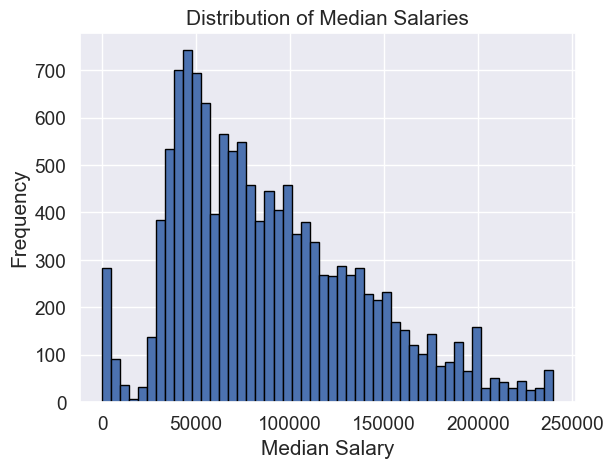

In [34]:
# Preprocessing and imputation
df.replace([np.nan], None, inplace = True)
# Calculate the average of max_salary and min_salary for rows where med_salary is NaN
df['med_salary'] = df.apply(calculate_med_salary, axis=1)
# Convert hourly wage to yearly wage
hours_in_year = 2080
df.loc[df['pay_period'] == 'HOURLY', ['min_salary', 'max_salary', 'med_salary']] *= hours_in_year
# Change 'HOURLY' to 'HOURLY_converted' to avoid re-execution of the conversion
df.loc[df['pay_period'] == 'HOURLY', 'pay_period'] = 'HOURLY_converted'


# Count how many rows now have a med_salary value
med_salary_count = df['med_salary'].notna().sum()
print(f"There are {med_salary_count} rows that list a salary")
plot_median_salary_distribution(df)

In [35]:
# Create a new DataFrame with only the 'med_salary' and 'description' columns
nlp_df = df[['med_salary', 'description']].dropna()

# Initialize TF-IDF Vectorizer
tfidf_vectorizer = TfidfVectorizer()

# Apply TF-IDF to the 'description' column of the new DataFrame
tfidf_matrix = tfidf_vectorizer.fit_transform(nlp_df['description'])

# The result is a sparse matrix where each row corresponds to a document (job description)
# and each column represents a word from the entire corpus' vocabulary.
# The values are the TF-IDF scores.

# For demonstration purposes, we can create a DataFrame with the TF-IDF scores for the first document
tfidf_df = pd.DataFrame(tfidf_matrix[0].T.todense(), index=tfidf_vectorizer.get_feature_names_out(), columns=["TF-IDF"])
tfidf_df = tfidf_df.sort_values('TF-IDF', ascending=False)

tfidf_df.head(100)  # Show the words with the highest TF-IDF scores for the first document

,TF-IDF
hearing,0.595568
hearinglife,0.236041
and,0.226670
aids,0.176521
care,0.164115
...,...
education,0.037179
dive,0.036814
leader,0.036497
member,0.036258


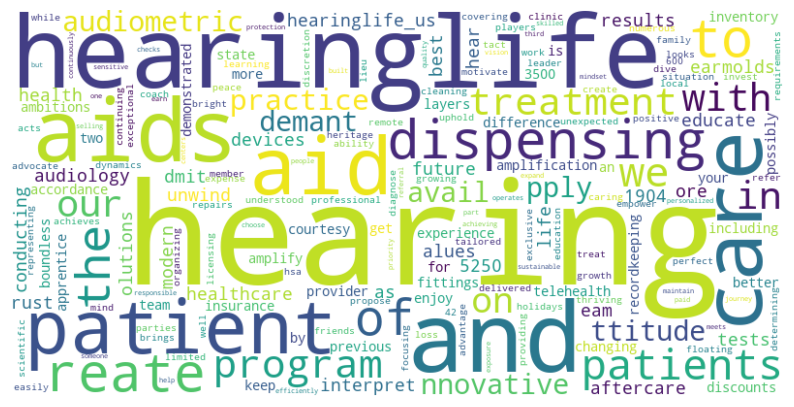

In [36]:
# Generate a word cloud for the first document's TF-IDF scores
wordcloud = WordCloud(background_color='white', width=800, height=400)

# Fit the word cloud with the scores
wordcloud.fit_words(tfidf_df['TF-IDF'].to_dict())

# Display the word cloud
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  # Remove the axis
plt.show()

In [37]:
# Create a single corpus by combining all job descriptions
combined_corpus = ' '.join(df['description'].dropna())
word_list = combined_corpus.split()

# Calculate frequency distribution for the combined corpus
combined_frequency_distribution = Counter(word_list)

# Total number of words in the corpus
total_words = len(word_list)

# Calculate probabilities for each word in the combined corpus
combined_probabilities = {word: count / total_words for word, count in combined_frequency_distribution.items()}

# Applying the adjusted entropy calculation to each job description
nlp_df['adjusted_combined_description_entropy'] = nlp_df['description'].apply(adjusted_combined_entropy)

# Displaying the first few rows with the new column
nlp_df.head()

,med_salary,description,adjusted_combined_description_entropy
0,5250.0,Overview\n\nHearingLife is a national hearing ...,3.561960
3,46321.6,descriptionTitle\n\n Looking for a great oppor...,2.480900
4,240895.0,"Job Summary\nAt iHerb, we are on a mission to ...",5.390484
8,40144.0,"descriptionTitle\n\n $2,000 Sign-on Bonus Guar...",1.436098
11,61000.0,Who We Are\n\nEscalent is an award-winning dat...,3.877941


In [38]:
# Create a new DataFrame with only the 'med_salary' and 'description' columns
nlp_df = df[['med_salary', 'description']].dropna()

# Initialize TF-IDF Vectorizer
tfidf_vectorizer = TfidfVectorizer()

# Apply TF-IDF to the 'description' column of the new DataFrame
tfidf_matrix = tfidf_vectorizer.fit_transform(nlp_df['description'])

# Creating a DataFrame with the TF-IDF scores for the first document
tfidf_df = pd.DataFrame(tfidf_matrix[0].T.todense(), index=tfidf_vectorizer.get_feature_names_out(), columns=["TF-IDF"])
tfidf_df = tfidf_df.sort_values('TF-IDF', ascending=False)

# Extracting the top 100 words with the highest TF-IDF scores for the first document
top_100_words = tfidf_df.head(100).index.tolist()

# Count the appearance of these 100 words in the dataset
word_counts = Counter()
for description in nlp_df['description']:
    words = description.split()
    word_counts.update(word for word in words if word in top_100_words)

word_counts.most_common(100)  # Display the 100 most common words among the top TF-IDF words

[('and', 417483),
 ('to', 223757),
 ('the', 182297),
 ('of', 161926),
 ('in', 109651),
 ('with', 96460),
 ('for', 90357),
 ('is', 58773),
 ('our', 44292),
 ('as', 43216),
 ('on', 41118),
 ('an', 32552),
 ('experience', 24534),
 ('by', 23209),
 ('your', 22226),
 ('team', 19480),
 ('we', 18895),
 ('including', 17745),
 ('more', 10219),
 ('care', 5802),
 ('professional', 5620),
 ('health', 5417),
 ('best', 5132),
 ('program', 4570),
 ('state', 3650),
 ('patient', 3538),
 ('life', 3430),
 ('education', 2924),
 ('insurance', 2880),
 ('healthcare', 2728),
 ('future', 2250),
 ('member', 2118),
 ('patients', 1992),
 ('accordance', 1948),
 ('results', 1808),
 ('leader', 1749),
 ('better', 1723),
 ('get', 1637),
 ('inventory', 1596),
 ('practice', 1431),
 ('two', 1202),
 ('changing', 1032),
 ('treatment', 969),
 ('difference', 876),
 ('enjoy', 833),
 ('keep', 788),
 ('provider', 776),
 ('demonstrated', 755),
 ('previous', 692),
 ('conducting', 684),
 ('interpret', 629),
 ('discounts', 475),
 ('h

In [39]:
# Prepare the target variable - median salary
y = nlp_df['med_salary']

# Initialize and train the Ridge Regression model
ridge_model = Ridge(alpha=1.0)
ridge_model.fit(tfidf_matrix, y)

# Get the coefficients for each word
coefficients = ridge_model.coef_

# Create a DataFrame for the coefficients
words = tfidf_vectorizer.get_feature_names_out()
coeff_df = pd.DataFrame({'Word': words, 'Coefficient': coefficients})

# Sort the DataFrame by the absolute values of coefficients to see which words have the most impact
coeff_df['Absolute Coefficient'] = coeff_df['Coefficient'].abs()
sorted_coeff_df = coeff_df.sort_values('Absolute Coefficient', ascending=False)

sorted_coeff_df.head(100)  # Display the top 100 words with the highest absolute coefficients

,Word,Coefficient,Absolute Coefficient
18173,cch,5.209265e+07,5.209265e+07
29103,directories,3.077088e+07,3.077088e+07
91772,touchtunes,2.532543e+07,2.532543e+07
84726,sponsorships,1.865824e+07,1.865824e+07
21669,compensationhybridmedical,1.699870e+07,1.699870e+07
...,...,...,...
45615,individualized,6.507819e+06,6.507819e+06
91801,toward,6.492718e+06,6.492718e+06
11557,articulate,6.453934e+06,6.453934e+06
7807,addressing,6.436376e+06,6.436376e+06


In [40]:
# Splitting the data into train and test sets (80-20 split)
X_train, X_test, y_train, y_test = train_test_split(tfidf_matrix, y, test_size=0.2, random_state=42)

# custom scoring function for R-squared
scorer = make_scorer(r2_score)

# Initialize Linear Regression model
linear_regression_model = LinearRegression()

# Lists to store training and validation losses for each epoch
train_losses = []
val_losses = []

# Number of training epochs
epochs = 100

# Perform 10-fold cross-validation on the training data
cross_val_scores = cross_val_score(linear_regression_model, X_train, y_train, cv=10, scoring=scorer)

# Print R-squared scores for each fold
for i, score in enumerate(cross_val_scores):
    print(f'R-squared (fold {i+1}): {score}')

# Training loop
for epoch in range(epochs):
    # Train the model on the training set
    linear_regression_model.fit(X_train, y_train)
    
    # Predict on the training set
    y_train_pred = linear_regression_model.predict(X_train)
    # Calculate and store the training loss (mean squared error)
    train_loss = mean_squared_error(y_train, y_train_pred)
    train_losses.append(train_loss)
    
    # Predict on the validation set
    y_val_pred = linear_regression_model.predict(X_test)
    # Calculate and store the validation loss (mean squared error)
    val_loss = mean_squared_error(y_test, y_val_pred)
    val_losses.append(val_loss)

R-squared (fold 1): -0.013042523141314266
R-squared (fold 2): -4245.994797211029
R-squared (fold 3): -3068.0153179664685
R-squared (fold 4): -8474.442334072972
R-squared (fold 5): -4478.670070405402
R-squared (fold 6): -84.31694190955463
R-squared (fold 7): -3471.2953178144476
R-squared (fold 8): -3723.7343138520546
R-squared (fold 9): -2816.714095135987
R-squared (fold 10): -0.5279497747835293


In [41]:
"""
These scores are very bad, mean squared error is in the millions, will have to try something else
"""

'\nThese scores are very bad, mean squared error is in the millions, will have to try something else\n'

In [42]:
# Initialize the StandardScaler
scaler = StandardScaler()

# Reshape y for scaling (as scaler expects 2D array)
y_reshaped = y.values.reshape(-1, 1)

# Fit the scaler to the target variable and transform
y_scaled = scaler.fit_transform(y_reshaped).flatten()

# Splitting the scaled data into train and test sets (80-20 split)
X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled = train_test_split(tfidf_matrix, y_scaled, test_size=0.2, random_state=42)

# Re-initialize and train the Linear Regression model on the scaled dataset
linear_regression_model_scaled = LinearRegression()
linear_regression_model_scaled.fit(X_train_scaled, y_train_scaled)

# Predict on the scaled test set
y_pred_scaled = linear_regression_model_scaled.predict(X_test_scaled)

# Calculate evaluation metrics for the scaled test set
mse_scaled = mean_squared_error(y_test_scaled, y_pred_scaled)
r2_scaled = r2_score(y_test_scaled, y_pred_scaled)

mse_scaled, r2_scaled

(1.0596816763719448, -2837.869539405521)

In [43]:
"""
After doing normalization on the median salary column (between [-1..1]), the scores
are now a lot more reasonable. But still not amazing.

Still, now onto interpretability stuff.
"""

'\nAfter doing normalization on the median salary column (between [-1..1]), the scores\nare now a lot more reasonable. But still not amazing.\n\nStill, now onto interpretability stuff.\n'

In [44]:
# Get the coefficients from the trained linear regression model on the scaled data
coefficients_scaled = linear_regression_model_scaled.coef_

# Create a DataFrame for these coefficients
words_scaled = tfidf_vectorizer.get_feature_names_out()
coeff_df_scaled = pd.DataFrame({'Word': words_scaled, 'Coefficient': coefficients_scaled})

# Sort the DataFrame by the absolute values of coefficients to see which words have the most impact
coeff_df_scaled['Absolute Coefficient'] = coeff_df_scaled['Coefficient'].abs()
sorted_coeff_df_scaled = coeff_df_scaled.sort_values('Absolute Coefficient', ascending=False)

sorted_coeff_df_scaled.head(100)  # Display the top 100 words with the highest absolute coefficients

,Word,Coefficient,Absolute Coefficient
18173,cch,54.653828,54.653828
21669,compensationhybridmedical,43.065596,43.065596
71794,ptocompany,40.805188,40.805188
29103,directories,39.981113,39.981113
73697,receptions,36.743225,36.743225
...,...,...,...
22687,connections,8.868141,8.868141
65981,pkfoda,-8.794840,8.794840
92846,trusted,8.794475,8.794475
87781,surveys,-8.776685,8.776685


In [45]:
# Calculating the mean TF-IDF score for each word across all documents
mean_tfidf_scores = np.mean(tfidf_matrix, axis=0)
mean_tfidf_df = pd.DataFrame(mean_tfidf_scores.T, index=words_scaled, columns=["Mean TF-IDF"])

# Filtering out the bottom 1% of words based on their mean TF-IDF scores
threshold = mean_tfidf_df['Mean TF-IDF'].quantile(0.01)
filtered_words_df = mean_tfidf_df[mean_tfidf_df['Mean TF-IDF'] > threshold]

# Selecting the top 100 words from the remaining words
top_100_filtered_words = filtered_words_df.sort_values('Mean TF-IDF', ascending=False).head(100)



# Re-initializing the TF-IDF Vectorizer to consider only the top 100 filtered words
filtered_tfidf_vectorizer = TfidfVectorizer(vocabulary=top_100_filtered_words.index)

# Applying TF-IDF to the 'description' column of the nlp_df using the filtered vocabulary
filtered_tfidf_matrix = filtered_tfidf_vectorizer.fit_transform(nlp_df['description'])

# Splitting the data into train and test sets (80-20 split) for the filtered TF-IDF matrix
X_train_filtered, X_test_filtered, y_train_filtered, y_test_filtered = train_test_split(filtered_tfidf_matrix, y_scaled, test_size=0.2, random_state=42)

# Initialize and train the Linear Regression model on the filtered dataset
filtered_linear_regression_model = LinearRegression()
filtered_linear_regression_model.fit(X_train_filtered, y_train_filtered)

# Predict on the filtered test set
y_pred_filtered = filtered_linear_regression_model.predict(X_test_filtered)

# Calculate evaluation metrics for the filtered test set
mse_filtered = mean_squared_error(y_test_filtered, y_pred_filtered)
r2_filtered = r2_score(y_test_filtered, y_pred_filtered)

mse_filtered, r2_filtered

(0.008457043256902736, -21.65627785284942)

In [46]:
# Get the coefficients from the trained linear regression model on the filtered scaled data
coefficients_filtered = filtered_linear_regression_model.coef_

# Create a DataFrame for these coefficients
filtered_words = filtered_tfidf_vectorizer.get_feature_names_out()
coeff_df_filtered = pd.DataFrame({'Word': filtered_words, 'Coefficient': coefficients_filtered})

# Sort the DataFrame by the absolute values of coefficients to see which words have the most impact
coeff_df_filtered['Absolute Coefficient'] = coeff_df_filtered['Coefficient'].abs()
sorted_coeff_df_filtered = coeff_df_filtered.sort_values('Absolute Coefficient', ascending=False)

sorted_coeff_df_filtered.head(100)  # Display the top 100 words with the highest absolute coefficients

,Word,Coefficient,Absolute Coefficient
50,development,0.798664,0.798664
26,business,0.563502,0.563502
91,about,0.528773,0.528773
47,client,0.476035,0.476035
35,other,0.469585,0.469585
...,...,...,...
12,as,-0.008851,0.008851
82,employees,-0.007832,0.007832
80,environment,0.003974,0.003974
44,required,0.003923,0.003923


example_description = input("")
predicted_salary = predict_salary(example_description, filtered_linear_regression_model, filtered_tfidf_vectorizer, scaler)
predicted_salary

# run time very long

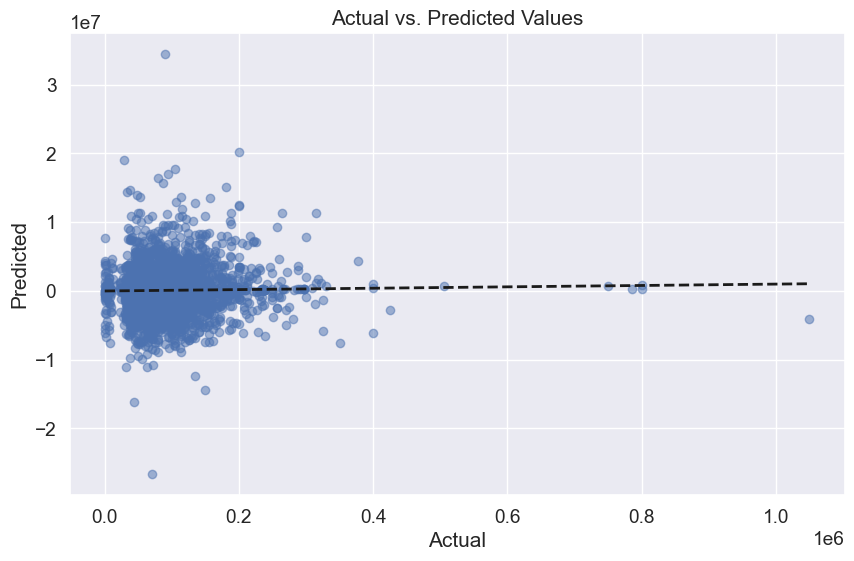

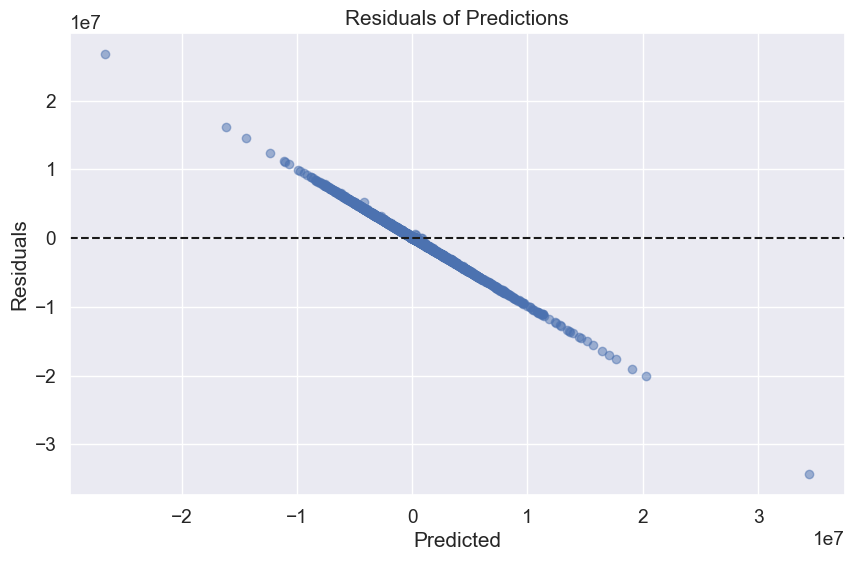

Mean Squared Error: 12365295254073.832
Root Mean Squared Error (RMSE): 3516432.176805609


In [47]:
linear_regression_model.fit(X_train, y_train)
y_pred = linear_regression_model.predict(X_test)

# Calculate residuals
residuals = y_test - y_pred

# Plotting the Actual vs Predicted values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)  # Diagonal line
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs. Predicted Values')
plt.show()

# Plotting the residuals
plt.figure(figsize=(10, 6))
plt.scatter(y_pred, residuals, alpha=0.5)
plt.axhline(y=0, color='k', linestyle='--')
plt.xlabel('Predicted')
plt.ylabel('Residuals')
plt.title('Residuals of Predictions')
plt.show()

# Calculate and print the MSE for good measure
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse}')

rmse = np.sqrt(mse)

print(f'Root Mean Squared Error (RMSE): {rmse}')


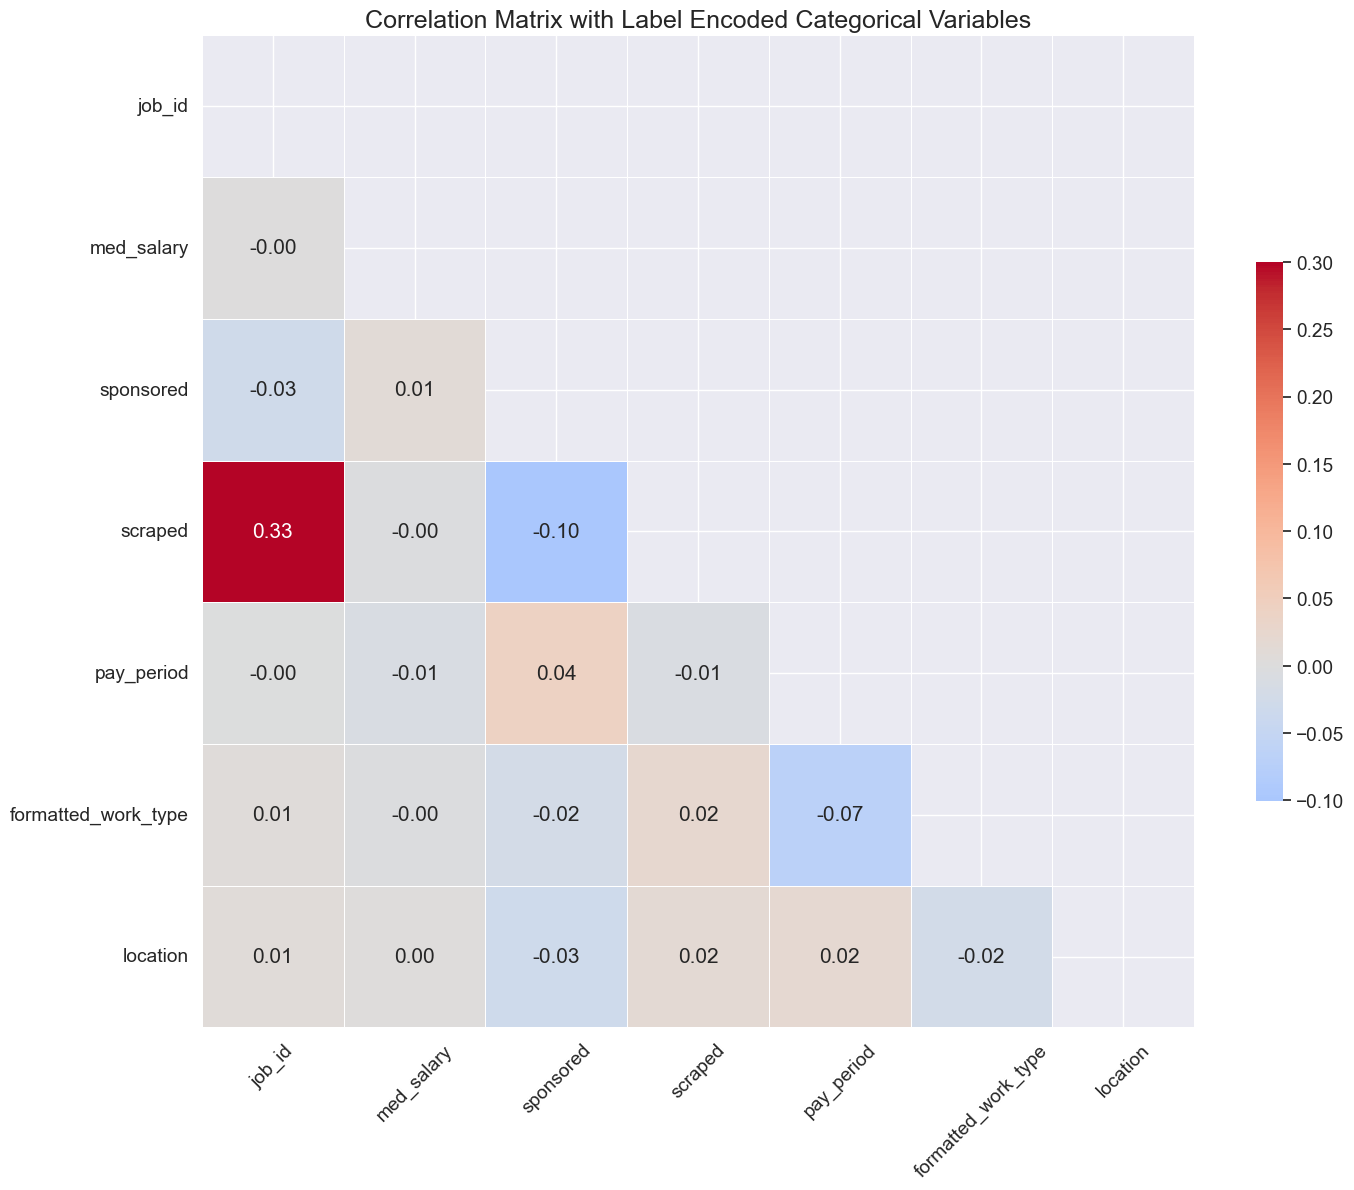

In [48]:
# numerical columns
numerical_df = df.select_dtypes(include=[np.number])

# categorical columns with relatively low cardinality
categorical_columns = ['pay_period', 'formatted_work_type', 'location']  # example of categorical columns

 
label_encoder = LabelEncoder()
for column in categorical_columns:
    if column in df.columns and df[column].dtype == 'object':
        # Fill NaNs with a placeholder string and convert to type str
        df[column] = df[column].fillna('Missing').astype(str)
        # Apply Label Encoding
        numerical_df[column] = label_encoder.fit_transform(df[column])

 
correlation_matrix = numerical_df.corr()

 
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))

 
plt.figure(figsize=(16, 14))

 
sns.heatmap(correlation_matrix, mask=mask, cmap='coolwarm', vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True, fmt=".2f")

 
sns.set(font_scale=1.25)

plt.title('Correlation Matrix with Label Encoded Categorical Variables', fontsize=18)
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.show()